# NN matrix decomposition for movie similarities

Collaborative filter:
Movies and customer embeddings.
Predict the rates as inner product of the two embeddings.

Extend:
1. replacing the inner product with a concat and a dense NN on top to make a neural collaborative filter.

How can we apply SVD to find similarities between movies?

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")

import sys
from pathlib import Path

sys.path.append(str(Path().absolute().parent))

import utilities

### Loading and transforming MovieLens

In [2]:
import utilities

ratings_df = utilities.load_ratings()
ratings_df

userId,movieId,rating,timestamp
i64,i64,f64,i64
1,5952,4.0,1147868053
1,2012,2.5,1147868068
1,2011,2.5,1147868079
1,1653,4.0,1147868097
1,1250,4.0,1147868414
…,…,…,…
162541,1259,4.5,1240953609
162541,1266,5.0,1240953613
162541,1556,1.0,1240953650


In [3]:
ratings_df["rating"].describe()

statistic,value
str,f64
"""count""",2.5000095e7
"""null_count""",0.0
"""mean""",3.533854
"""std""",1.060744
"""min""",0.5
"""25%""",3.0
"""50%""",3.5
"""75%""",4.0
"""max""",5.0


Train on a smaller subset to make life easier for iterating.

In [4]:
top_movie_ids = utilities.get_most_frequent_movies(ratings_df)
ratings_df = ratings_df.join(top_movie_ids, on="movieId", how="inner")

There are fewer MovieId than the max MovieId. So we map movieIds to a compressed set. Also userId needs to be indexed from 1.

In [5]:
ratings_df["movieId"].max(), ratings_df["movieId"].unique().len()

(79132, 50)

In [6]:
def map_users_and_movies(ratings_df):
    user_id_mapping = (
        ratings_df[["userId"]]
        .unique()
        .sort("userId")
        .with_row_index(name="userIdMapped")
    )
    movie_id_mapping = (
        ratings_df[["movieId"]]
        .unique()
        .sort("movieId")
        .with_row_index(name="movieIdMapped")
    )
    ratings_df = ratings_df.join(user_id_mapping, on="userId", how="left").join(
        movie_id_mapping, on="movieId", how="left"
    )
    return ratings_df, user_id_mapping, movie_id_mapping


ratings_df, user_id_mapping, movie_id_mapping = map_users_and_movies(ratings_df)
ratings_df

userId,movieId,rating,timestamp,userIdMapped,movieIdMapped
i64,i64,f64,i64,u32,u32
1,5952,4.0,1147868053,0,46
1,296,5.0,1147880044,0,7
2,5952,5.0,1141415528,1,46
2,150,4.0,1141415790,1,5
2,3578,5.0,1141415803,1,42
…,…,…,…,…,…
162541,1136,4.5,1240953505,157480,25
162541,296,3.5,1240953510,157480,7
162541,1197,4.5,1240953534,157480,27


Make into torch datasets

Make a sample dataset with about 5% of the total data for testing.

In [7]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.model_selection import train_test_split


def create_tensor_dataset(data):
    user_ids = torch.tensor(data["userIdMapped"], dtype=torch.long)
    item_ids = torch.tensor(data["movieIdMapped"], dtype=torch.long)
    ratings = torch.tensor(data["rating"], dtype=torch.float)
    return TensorDataset(user_ids, item_ids, ratings)


train_data, _val_data = train_test_split(ratings_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(_val_data, test_size=1 / 3, random_state=42)

dataset_train = create_tensor_dataset(train_data)
dataset_val = create_tensor_dataset(val_data)
dataset_test = create_tensor_dataset(test_data)

dataset_train_sample = create_tensor_dataset(train_data.head(int(1e5)))
dataset_val_sample = create_tensor_dataset(val_data.head(int(1e5)))

In [8]:
dataloader_train = DataLoader(
    dataset_train,
    batch_size=2**12,
    shuffle=True,
)
dataloader_val = DataLoader(
    dataset_val,
    batch_size=2**12,
)
dataloader_test = DataLoader(
    dataset_test,
    batch_size=2**12,
)

dataloader_train_sample = DataLoader(
    dataset_train_sample,
    batch_size=2**12,
    shuffle=False,
)
dataloader_val_sample = DataLoader(
    dataset_val_sample,
    batch_size=2**12,
)

### Model definition

Fit a model to learn embeddings

In [9]:
import torch.nn as nn
import pytorch_lightning as pyl


class MovieEmbeddingModel(pyl.LightningModule):
    def __init__(self, n_users, n_movies, embedding_dim=10):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)
        self.output = nn.Linear(1, 1)
        self.sigmoid = nn.Sigmoid()
        self.max_rating = 5.0
        self.min_rating = 0.5
        self.output_bias = torch.logit(
            torch.tensor((3.9 - self.min_rating) / (self.max_rating - self.min_rating))
        )
        self.output.bias.data.fill_(self.output_bias)
        self.learning_rate = 5e-3

    def forward(self, user_ids, movie_ids):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        output = self.output((user_embeds * movie_embeds).sum(dim=1).view(-1, 1))
        rating = (
            self.sigmoid(output) * (self.max_rating - self.min_rating) + self.min_rating
        )
        return rating.flatten()

    def training_step(self, batch, batch_idx):
        user_ids, movie_ids, ratings = batch
        predictions = self(user_ids, movie_ids)
        loss = nn.MSELoss()(predictions, ratings)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        user_ids, movie_ids, ratings = batch
        predictions = self(user_ids, movie_ids)
        loss = nn.MSELoss()(predictions, ratings)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

Check it works with a small sample

In [10]:
n_users = ratings_df["userIdMapped"].unique().count()
n_movies = ratings_df["movieIdMapped"].unique().count()
batch = next(iter(dataloader_train_sample))
model = MovieEmbeddingModel(n_users, n_movies)
model(batch[0], batch[1])

tensor([4.1883, 2.0943, 1.9674,  ..., 4.3297, 1.9700, 1.2076],
       grad_fn=<ViewBackward0>)

Custom logger to store metrics in python dictionaries

In [11]:
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities import rank_zero_only


class DictLogger(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = {}

    @property
    def name(self):
        return "DictLogger"

    @property
    def version(self):
        return "1.0"

    @rank_zero_only
    def log_hyperparams(self, params):
        pass

    @rank_zero_only
    def log_metrics(self, metrics, step):
        for k, v in metrics.items():
            if k not in self.metrics:
                self.metrics[k] = []
            self.metrics[k].append((step, v))

    def save(self):
        pass

    @rank_zero_only
    def finalize(self, status):
        pass

Add early stopping and enforce a minimum of 6 epochs (it takes a few epochs to start improving over a mean baseline)

In [12]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import Callback


class EarlyStoppingWithMinEpochs(Callback):
    def __init__(self, min_epochs, **kwargs):
        super().__init__()
        self.min_epochs = min_epochs
        self.early_stopping = EarlyStopping(**kwargs)

    def on_validation_end(self, trainer, pl_module):
        if trainer.current_epoch >= self.min_epochs - 1:
            self.early_stopping.on_validation_end(trainer, pl_module)

    def on_train_end(self, trainer, pl_module):
        self.early_stopping.on_train_end(trainer, pl_module)


early_stop_callback = EarlyStoppingWithMinEpochs(
    min_epochs=6, monitor="val_loss", patience=3, mode="min"
)

Train the model

Using an embedding size of 5.

In [13]:
logger = DictLogger()
model = MovieEmbeddingModel(n_users, n_movies, embedding_dim=5)
trainer = pyl.Trainer(
    max_epochs=40,
    logger=logger,
    log_every_n_steps=1,
    callbacks=[early_stop_callback],
)
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type      | Params | Mode 
------------------------------------------------------
0 | user_embedding  | Embedding | 787 K  | train
1 | movie_embedding | Embedding | 250    | train
2 | output          | Linear    | 2      | train
3 | sigmoid         | Sigmoid   | 0      | train
------------------------------------------------------
787 K     Trainable params
0         Non-trainable params
787 K     Total params
3.151     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 13: 100%|██████████| 435/435 [00:21<00:00, 20.40it/s, v_num=1.0, train_loss_step=0.470, val_loss_step=0.705, val_loss_epoch=0.751, train_loss_epoch=0.474]


Plotting train/val epoch loss

Looks like we are learning reasonably well.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_89842/3291496198.py:19: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=["epoch", "batch"], variable_name="dataset", value_name="loss")
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_89842/3291496198.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


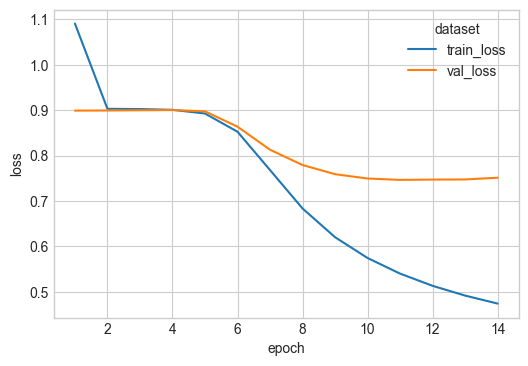

In [14]:
def training_logs_to_df(logger, name:str=None):
    df = (
        pl.concat(
            [
                pl.DataFrame(
                    logger.metrics["train_loss_epoch"],
                    orient="row",
                    schema=["batch", "train_loss"],
                ),
                pl.DataFrame(
                    logger.metrics["val_loss_epoch"],
                    orient="row",
                    schema=["batch", "val_loss"],
                ).drop("batch"),
            ],
            how="horizontal",
        )
        .with_row_index(name="epoch", offset=1)
        .melt(id_vars=["epoch", "batch"], variable_name="dataset", value_name="loss")
    )
    if name:
        df = df.with_columns(pl.lit(name).alias("name"))
    return df

plot_df = training_logs_to_df(logger, name='nn_inner')


fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="epoch", y="loss", hue="dataset", ax=ax)
fig.show()

### Check prediction results

We will use a baseline prediction from mean ratings

In [15]:
x = train_data

x = x.with_columns(pl.col("rating").mean().alias("baseline"))

preds = model(torch.tensor(x["userIdMapped"]), torch.tensor(x["movieIdMapped"]))
x = x.with_columns(pl.lit(preds.detach().numpy()).alias("nn"))

x

userId,movieId,rating,timestamp,userIdMapped,movieIdMapped,baseline,nn
i64,i64,f64,i64,u32,u32,f64,f32
5150,79132,2.5,1459431773,5008,49,3.979833,3.03994
79646,150,3.5,1554224374,77175,5,3.979833,3.884991
63956,318,4.0,948005318,61981,8,3.979833,4.502549
66248,1291,4.5,1189775094,64204,33,3.979833,3.952633
57849,527,4.5,1322993994,56060,16,3.979833,3.968396
…,…,…,…,…,…,…,…
7160,780,3.0,848676694,6942,23,3.979833,2.745047
108304,527,4.0,1419181402,104945,16,3.979833,3.78171
150532,380,3.5,1181551976,145835,13,3.979833,2.853964


We are beating the mean baseline in the training dataset

In [16]:
print(
    "baseline loss: ",
    nn.MSELoss()(torch.tensor(x["baseline"]), torch.tensor(x["rating"])),
)
print("NN loss: ", nn.MSELoss()(torch.tensor(x["nn"]), torch.tensor(x["rating"])))

baseline loss:  tensor(0.9037)
NN loss:  tensor(0.4451)


The histogram of predictions looks reasonable

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_89842/3248393641.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


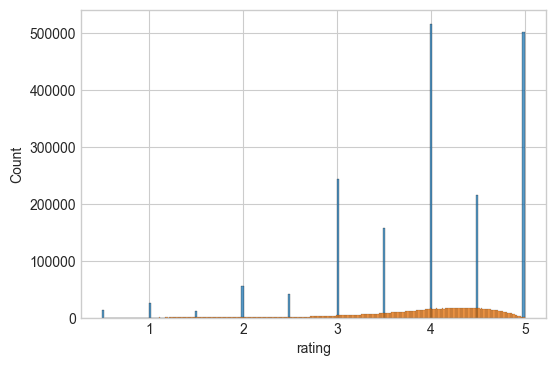

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(x, x="rating", ax=ax)
sns.histplot(x, x="nn", ax=ax)
fig.show()

### Get embeddings

Get movie embeddings from the model layers and store for later use.

In [18]:
from pathlib import Path

movie_embeddings_df = ratings_df["movieId", "movieIdMapped"].unique().sort("movieId")
# movie_embeddings_df.with_columns(pl.col('movieIdMapped').map_elements(lambda x: model.movie_embedding(torch.tensor(x)).detach().numpy(),return_dtype=pl.List(pl.Float32)))
movie_embeddings_df = pl.concat(
    [movie_embeddings_df, pl.DataFrame(model.movie_embedding.weight.detach().numpy())],
    how="horizontal",
).drop("movieIdMapped")
display(movie_embeddings_df)

Path("../data/embeddings").mkdir(parents=True, exist_ok=True)
movie_embeddings_df.write_parquet("../data/embeddings/nn.parquet")

movieId,column_0,column_1,column_2,column_3,column_4
i64,f32,f32,f32,f32,f32
1,-1.272084,-0.994629,-0.220356,-0.189384,-0.986966
32,-0.862826,0.03853,1.001704,-0.68009,-0.601631
47,-0.673808,-0.653811,0.591152,-1.096568,-0.157232
50,-0.260233,-0.903206,0.558693,-1.380012,0.428046
110,-1.426404,-0.878591,0.510824,-0.494181,-0.277539
…,…,…,…,…,…
4993,-0.832353,-1.856606,-2.038899,-0.467682,-0.561474
5952,-0.823814,-2.014611,-2.101298,-0.460424,-0.619018
7153,-0.907353,-1.942751,-2.122972,-0.368461,-0.459154


# Appendix

In [ ]:
raise NotImplementedError

NotImplementedError: 

### Pick batch size

Change batch size, test time for iteration, calculate time for epoch

In [ ]:
import timeit

batch_sizes = [2**i for i in range(8, 17)]
batch_training_time = []
trainer = pyl.Trainer(
    max_epochs=1,
    logger=logger,
    log_every_n_steps=1,
    enable_progress_bar=False,
    enable_model_summary=False,
)
for batch_size in batch_sizes:
    print(f"Training with batch size {batch_size}")
    dataloader_train_sample = DataLoader(
        dataset_train_sample,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
    )
    dataloader_val_sample = DataLoader(
        dataset_val_sample, batch_size=batch_size, num_workers=4
    )

    logger = DictLogger()
    t1 = timeit.default_timer()
    trainer.fit(model, dataloader_train_sample, dataloader_val_sample)
    t2 = timeit.default_timer()
    batch_training_time.append((batch_size, t2 - t1))


for a in batch_training_time:
    print(a)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with batch size 256


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/unfinished-movie_similarity/DictLogger/1.0/checkpoints exists and is not empty.
/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 512


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 1024


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 2048


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 4096


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 8192


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 16384


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 32768


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with batch size 65536


`Trainer.fit` stopped: `max_epochs=1` reached.


(256, 11.856541125103831)
(512, 4.736162832938135)
(1024, 3.898271417012438)
(2048, 3.8875532089732587)
(4096, 5.152088291943073)
(8192, 4.3516676251310855)
(16384, 5.048533875029534)
(32768, 4.2527649169787765)
(65536, 5.126805416774005)


### Num workers

In [ ]:
import timeit

num_workers_range = range(0, 8)
num_workers_training_time = []
trainer = pyl.Trainer(
    max_epochs=1,
    logger=logger,
    log_every_n_steps=1,
    enable_progress_bar=False,
    enable_model_summary=False,
)
for num_workers in num_workers_range:
    print(f"Training with num_workers {num_workers}")
    dataloader_train_sample = DataLoader(
        dataset_train_sample,
        batch_size=2**12,
        shuffle=False,
        num_workers=num_workers,
    )
    dataloader_val_sample = DataLoader(
        dataset_val_sample, batch_size=2**12, num_workers=num_workers
    )

    logger = DictLogger()
    t1 = timeit.default_timer()
    trainer.fit(model, dataloader_train_sample, dataloader_val_sample)
    t2 = timeit.default_timer()
    num_workers_training_time.append((num_workers, t2 - t1))


for a in num_workers_training_time:
    print(a)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training with num_workers 0


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 1


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 2


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 3


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 4


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 5


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 6


`Trainer.fit` stopped: `max_epochs=1` reached.


Training with num_workers 7


`Trainer.fit` stopped: `max_epochs=1` reached.


(0, 3.0349692499730736)
(1, 3.4903268748894334)
(2, 4.375782374991104)
(3, 4.357490375172347)
(4, 5.5021544171031564)
(5, 4.955234291963279)
(6, 7.25182820786722)
(7, 9.90799583401531)


### Test training on a sample

In [ ]:
n_users = ratings_df["userIdMapped"].unique().count()
n_movies = ratings_df["movieIdMapped"].unique().count()
logger_sample = DictLogger()
model_sample = MovieEmbeddingModel(n_users, n_movies, embedding_dim=5)
trainer = pyl.Trainer(max_epochs=40, logger=logger_sample, log_every_n_steps=1)
trainer.fit(model_sample, dataloader_train_sample, dataloader_val_sample)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/stantoon/Documents/VariousProjects/github/data-analysis/neural_networks/unfinished-movie_similarity/DictLogger/1.0/checkpoints exists and is not empty.

  | Name            | Type      | Params | Mode 
------------------------------------------------------
0 | user_embedding  | Embedding | 787 K  | train
1 | movie_embedding | Embedding | 250    | train
2 | output          | Linear    | 2      | train
3 | sigmoid         | Sigmoid   | 0      | train
------------------------------------------------------
787 K     Trainable params
0         Non-trainable params
787 K     Total params
3.151     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/stantoon/Documents/VariousProjects/github/data-analysis/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 10.77it/s, v_num=1.0, train_loss_step=0.0389, val_loss_step=2.320, val_loss_epoch=2.210, train_loss_epoch=0.0748]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 10.67it/s, v_num=1.0, train_loss_step=0.0389, val_loss_step=2.320, val_loss_epoch=2.210, train_loss_epoch=0.0748]


### Training loss

We need a few epochs until the model starts to converge to somewhere useful.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_8116/3972096283.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


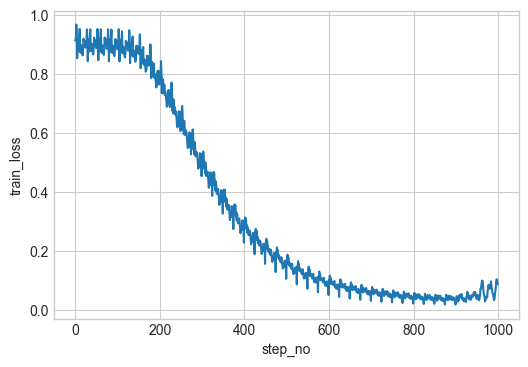

In [ ]:
plot_df = pl.DataFrame(
    logger_sample.metrics["train_loss_step"],
    orient="row",
    schema=["batch", "train_loss"],
).with_row_index(name="step_no")

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="step_no", y="train_loss", ax=ax)
fig.show()

Train/val epoch loss

We are able to overfit. Need:
1. use the larger dataset - **this works**
2. some regulariation
3. expand the embedding size

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_8116/45602504.py:21: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  .melt(id_vars=["step_no", "batch"], variable_name="dataset", value_name="loss")
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_8116/45602504.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


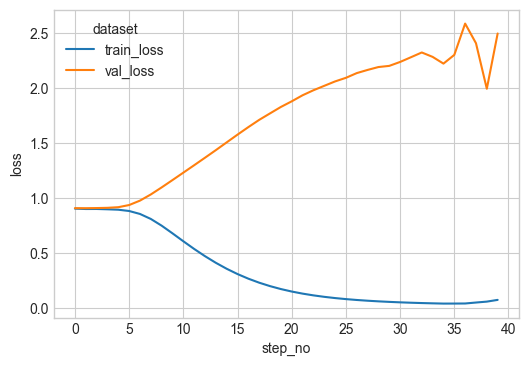

In [ ]:
plot_df = (
    pl.concat(
        [
            pl.DataFrame(
                logger_sample.metrics["train_loss_epoch"],
                orient="row",
                schema=["batch", "train_loss"],
            ),
            pl.DataFrame(
                logger_sample.metrics["val_loss_epoch"],
                orient="row",
                schema=["batch", "val_loss"],
            ).drop("batch"),
        ],
        how="horizontal",
    )
    .with_row_index(name="step_no")
    .melt(id_vars=["step_no", "batch"], variable_name="dataset", value_name="loss")
)


fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, x="step_no", y="loss", hue="dataset", ax=ax)
fig.show()

### Check prediction results

In [ ]:
preds, ratings = [], []
for idx, batch in enumerate(dataloader_train_sample):
    _user_ids, _movie_ids, _ratings = batch
    _pred = model(_user_ids, _movie_ids)
    preds.append(_pred.detach().numpy())
    ratings.append(_ratings.detach().numpy())

preds = np.concatenate(preds)
ratings = np.concatenate(ratings)

Baseline prediction from mean rating

In [ ]:
x = train_data.head(int(1e5))
x = x.with_columns(pl.col("rating").mean().alias("baseline"), pl.lit(preds).alias("nn"))
x

userId,movieId,rating,timestamp,userIdMapped,movieIdMapped,baseline,nn
i64,i64,f64,i64,u32,u32,f64,f32
67708,2959,5.0,972622556,65623,41,3.977185,4.873698
91505,1198,5.0,949716859,88679,28,3.977185,4.848859
43849,1136,5.0,881632083,42520,25,3.977185,4.921653
34745,344,4.0,1134517613,33693,9,3.977185,3.932611
77573,364,4.0,1009228452,75160,11,3.977185,3.934654
…,…,…,…,…,…,…,…
109740,1196,3.0,1536930155,106339,26,3.977185,3.00328
136800,58559,4.0,1395708644,132548,48,3.977185,3.981432
139513,1265,4.0,1223914026,135162,31,3.977185,4.010388


MSE looks good on training set

In [ ]:
(
    nn.MSELoss()(torch.tensor(x["baseline"]), torch.tensor(x["rating"])),
    nn.MSELoss()(torch.tensor(x["nn"]), torch.tensor(x["rating"])),
)

(tensor(0.8981), tensor(0.0711))

<Axes: xlabel='rating', ylabel='Count'>

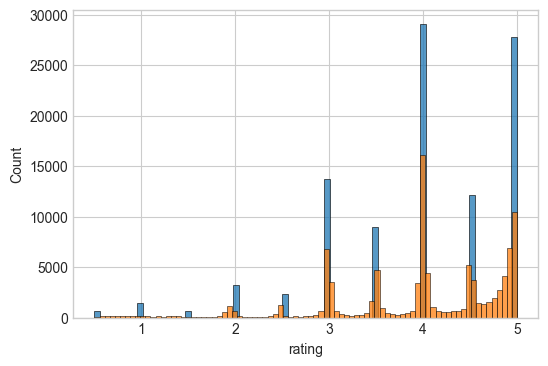

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(x, x="rating", ax=ax)
sns.histplot(x, x="nn", ax=ax)
fig.show()